In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Dataset/Tiny.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [24]:
image_size=(224,224)
transform_train = transforms.Compose([
     transforms.ToTensor()
])

transform_test = transforms.Compose([
     transforms.ToTensor()
])

In [25]:
train_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/validation', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/test', transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True, drop_last=False,num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)

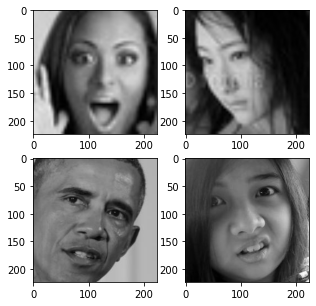

In [26]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

plot_data_loader(train_loader, (2, 2))

In [27]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Number of classes: 13
Train Size: 9620
Test Size: 4784
Validation Size: 3952


In [28]:
torch.cuda.empty_cache()

In [29]:
model = models.shufflenet_v2_x1_0(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


In [30]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 30
for epoch in range(num_epochs):
 
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    

    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    lr_sched.step()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/30 | Train Loss: 2.1617 | Train Acc: 0.1544 | Val Loss: 2.4639 | Val Acc: 0.1482


Epoch 1/30: 100%|██████████| 76/76 [00:06<00:00, 11.16batch/s]


Epoch 2/30 | Train Loss: 2.0746 | Train Acc: 0.1792 | Val Loss: 2.1785 | Val Acc: 0.1814


Epoch 2/30: 100%|██████████| 76/76 [00:06<00:00, 11.29batch/s]


Epoch 3/30 | Train Loss: 2.0113 | Train Acc: 0.2206 | Val Loss: 1.8150 | Val Acc: 0.2660


Epoch 3/30: 100%|██████████| 76/76 [00:06<00:00, 11.17batch/s]


Epoch 4/30 | Train Loss: 1.7927 | Train Acc: 0.2840 | Val Loss: 1.6784 | Val Acc: 0.3452


Epoch 4/30: 100%|██████████| 76/76 [00:06<00:00, 11.29batch/s]


Epoch 5/30 | Train Loss: 1.6466 | Train Acc: 0.3457 | Val Loss: 1.5914 | Val Acc: 0.3708


Epoch 5/30: 100%|██████████| 76/76 [00:06<00:00, 11.20batch/s]


Epoch 6/30 | Train Loss: 1.4857 | Train Acc: 0.4186 | Val Loss: 1.2824 | Val Acc: 0.4930


Epoch 6/30: 100%|██████████| 76/76 [00:06<00:00, 11.30batch/s]


Epoch 7/30 | Train Loss: 1.3091 | Train Acc: 0.4848 | Val Loss: 1.0464 | Val Acc: 0.6085


Epoch 7/30: 100%|██████████| 76/76 [00:06<00:00, 11.21batch/s]


Epoch 8/30 | Train Loss: 0.7813 | Train Acc: 0.7529 | Val Loss: 0.6323 | Val Acc: 0.8239


Epoch 8/30: 100%|██████████| 76/76 [00:06<00:00, 11.10batch/s]


Epoch 9/30 | Train Loss: 0.5331 | Train Acc: 0.8617 | Val Loss: 0.4085 | Val Acc: 0.9227


Epoch 9/30: 100%|██████████| 76/76 [00:06<00:00, 11.29batch/s]


Epoch 10/30 | Train Loss: 0.3401 | Train Acc: 0.9435 | Val Loss: 0.2388 | Val Acc: 0.9773


Epoch 10/30: 100%|██████████| 76/76 [00:06<00:00, 11.15batch/s]


Epoch 11/30 | Train Loss: 0.2207 | Train Acc: 0.9760 | Val Loss: 0.1352 | Val Acc: 0.9955


Epoch 11/30: 100%|██████████| 76/76 [00:06<00:00, 11.18batch/s]


Epoch 12/30 | Train Loss: 0.1361 | Train Acc: 0.9923 | Val Loss: 0.0750 | Val Acc: 0.9989


Epoch 12/30: 100%|██████████| 76/76 [00:06<00:00, 11.22batch/s]


Epoch 13/30 | Train Loss: 0.0973 | Train Acc: 0.9941 | Val Loss: 0.0508 | Val Acc: 0.9990


Epoch 13/30: 100%|██████████| 76/76 [00:06<00:00, 11.32batch/s]


Epoch 14/30 | Train Loss: 0.0739 | Train Acc: 0.9947 | Val Loss: 0.0387 | Val Acc: 0.9989


Epoch 14/30: 100%|██████████| 76/76 [00:06<00:00, 11.23batch/s]


Epoch 15/30 | Train Loss: 0.0609 | Train Acc: 0.9954 | Val Loss: 0.0312 | Val Acc: 0.9996


Epoch 15/30: 100%|██████████| 76/76 [00:06<00:00, 11.32batch/s]


Epoch 16/30 | Train Loss: 0.0550 | Train Acc: 0.9967 | Val Loss: 0.0316 | Val Acc: 0.9996


Epoch 16/30: 100%|██████████| 76/76 [00:06<00:00, 11.31batch/s]


Epoch 17/30 | Train Loss: 0.0501 | Train Acc: 0.9980 | Val Loss: 0.0261 | Val Acc: 0.9996


Epoch 17/30: 100%|██████████| 76/76 [00:06<00:00, 11.19batch/s]


Epoch 18/30 | Train Loss: 0.0487 | Train Acc: 0.9974 | Val Loss: 0.0251 | Val Acc: 0.9996


Epoch 18/30: 100%|██████████| 76/76 [00:06<00:00, 11.12batch/s]


Epoch 19/30 | Train Loss: 0.0500 | Train Acc: 0.9968 | Val Loss: 0.0246 | Val Acc: 0.9996


Epoch 19/30: 100%|██████████| 76/76 [00:06<00:00, 11.24batch/s]


Epoch 20/30 | Train Loss: 0.0443 | Train Acc: 0.9983 | Val Loss: 0.0218 | Val Acc: 0.9996


Epoch 20/30: 100%|██████████| 76/76 [00:06<00:00, 11.27batch/s]


Epoch 21/30 | Train Loss: 0.0461 | Train Acc: 0.9971 | Val Loss: 0.0223 | Val Acc: 0.9996


Epoch 21/30: 100%|██████████| 76/76 [00:06<00:00, 11.09batch/s]


Epoch 22/30 | Train Loss: 0.0417 | Train Acc: 0.9989 | Val Loss: 0.0209 | Val Acc: 0.9996


Epoch 22/30: 100%|██████████| 76/76 [00:06<00:00, 11.27batch/s]


Epoch 23/30 | Train Loss: 0.0440 | Train Acc: 0.9981 | Val Loss: 0.0212 | Val Acc: 0.9996


Epoch 23/30: 100%|██████████| 76/76 [00:06<00:00, 11.22batch/s]


Epoch 24/30 | Train Loss: 0.0405 | Train Acc: 0.9982 | Val Loss: 0.0211 | Val Acc: 0.9996


Epoch 24/30: 100%|██████████| 76/76 [00:06<00:00, 11.21batch/s]


Epoch 25/30 | Train Loss: 0.0414 | Train Acc: 0.9983 | Val Loss: 0.0207 | Val Acc: 0.9996


Epoch 25/30: 100%|██████████| 76/76 [00:06<00:00, 11.25batch/s]


Epoch 26/30 | Train Loss: 0.0412 | Train Acc: 0.9980 | Val Loss: 0.0216 | Val Acc: 0.9996


Epoch 26/30: 100%|██████████| 76/76 [00:06<00:00, 11.33batch/s]


Epoch 27/30 | Train Loss: 0.0434 | Train Acc: 0.9988 | Val Loss: 0.0200 | Val Acc: 0.9996


Epoch 27/30: 100%|██████████| 76/76 [00:06<00:00, 11.19batch/s]


Epoch 28/30 | Train Loss: 0.0419 | Train Acc: 0.9977 | Val Loss: 0.0199 | Val Acc: 0.9996


Epoch 28/30: 100%|██████████| 76/76 [00:06<00:00, 11.12batch/s]


Epoch 29/30 | Train Loss: 0.0387 | Train Acc: 0.9983 | Val Loss: 0.0202 | Val Acc: 0.9996


Epoch 29/30: 100%|██████████| 76/76 [00:06<00:00, 11.29batch/s]


Epoch 30/30 | Train Loss: 0.0408 | Train Acc: 0.9983 | Val Loss: 0.0218 | Val Acc: 0.9996


Epoch 30/30: 100%|██████████| 76/76 [00:06<00:00, 11.16batch/s]


In [31]:
val_accs = torch.tensor(val_accs)
train_accs=torch.tensor(train_accs)

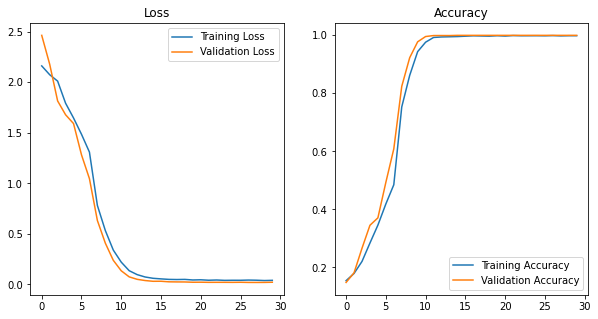

In [32]:
train_accs = [acc.item() for acc in train_accs]
val_accs = torch.tensor(val_accs)  
test_accs = [acc.item() for acc in val_accs]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Accuracy of the model on the 4784 test images: 57.37876254180602 %


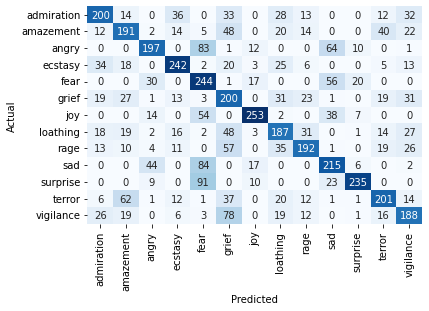

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


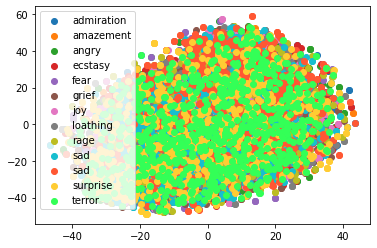

In [36]:
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

label_names = ['admiration', 'amazement', 'angry','ecstasy','fear','grief','joy','loathing','rage','sad','sad','surprise','terror']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff5733', '#ffcc33', '#33ff57', '#33ffcc', '#5733ff', '#cc33ff']


shufflenet = models.shufflenet_v2_x1_0(pretrained=False)

shufflenet = torch.nn.Sequential(*list(shufflenet.children())[:-1])

shufflenet.eval()


features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        outputs = shufflenet(images)
        features.append(outputs.view(outputs.size(0), -1).numpy())
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()